# 糖尿病预测数据预处理与建模（基于 BRFSS 数据集）

本 Notebook 包括以下模块：

- 数据划分与标准化  
- 类别分布检查与上采样  
- 标准化可视化  
- XGBoost 模型训练与评估  


In [1]:
import os
from sklearn.utils import resample
from sklearn.metrics import precision_score, recall_score, f1_score
from xgboost import plot_importance
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import plot_importance
# 基础库
import numpy as np
import pandas as pd

# 机器学习
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                           accuracy_score, precision_recall_curve, roc_auc_score)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# 树模型
import xgboost as xgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier  # 需要单独安装：pip install lightgbm

# 可视化
import matplotlib.pyplot as plt
import seaborn as sns

# 对数据进行预处理

In [19]:

import pandas as pd
from sklearn.preprocessing import StandardScaler

# 🔶 1. 读取原始 CSV
df = pd.read_csv('data/CDC_BRFSS2015.csv')

# 🔶 2. 字段重命名
df.columns = [
    'Diabetes_binary', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
    'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
    'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth',
    'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income'
]

# 🔶 3. 删除异常 BMI
df = df[df['BMI'].between(10, 60)]

# 🔶 4. 添加 IsObese 标签（用于逻辑判断）
df['IsObese'] = (df['BMI'] >= 30).astype(int)

# 🔶 5. 构造 HealthRiskScore（保守方式）
df['HealthRiskScore'] = df['MentHlth'] + df['PhysHlth']

final_cols = [
    'HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke',
    'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
    'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk',
    'Sex', 'Age', 'Education', 'Income', 'BMI', 'IsObese', 'HealthRiskScore',
    'Diabetes_binary'
]
df_final = df[final_cols]

# 🔶 8. 输出处理结果
df_final.to_csv('aftprocessdata/processed_brfss.csv', index=False)
print("✅ 已生成优化后的文件：processed_brfss_v2.csv")



✅ 已生成优化后的文件：processed_brfss_v2.csv


# 加载数据（请确保已预处理为 processed_brfss.csv）

In [20]:

data = pd.read_csv('aftprocessdata/processed_brfss.csv')
data.head()
#类别数量检查
print("Class 0:", (data.iloc[:,-1] == 0).sum())
print("Class 1:", (data.iloc[:,-1] == 1).sum())


Class 0: 217700
Class 1: 35175


# 上采样函数定义与执行
复制少数类样本使其数量增加到与多数类相等，这样可以平衡训练数据的正负样本数量；


In [21]:
def oversample(df):
    if ((df.iloc[:,-1] == 0).sum()) >= ((df.iloc[:,-1] == 1).sum()):
        df_majority = df[df.iloc[:,-1] == 0]
        df_minority = df[df.iloc[:,-1] == 1]
    else:
        df_majority = df[df.iloc[:,-1] == 1]
        df_minority = df[df.iloc[:,-1] == 0]
    df_minority_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=42)
    df_upsampled = pd.concat([df_majority, df_minority_upsampled])
    return df_upsampled.sample(frac=1, random_state=0).reset_index(drop=True)

# 执行上采样
data_balanced = oversample(data)
data_balanced['Diabetes_binary'].value_counts()


Diabetes_binary
0.0    217700
1.0    217700
Name: count, dtype: int64

# 数据划分以及标准化

In [22]:
def data_split(df):
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]
    return train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

def data_scaling(train_x, test_x):
    scaler = StandardScaler()
    train_x_scaled = scaler.fit_transform(train_x)
    test_x_scaled = scaler.transform(test_x)
    return train_x_scaled, test_x_scaled

# 执行划分与标准化
train_x, test_x, train_y, test_y = data_split(data_balanced)
train_x_scaled, test_x_scaled = data_scaling(train_x, test_x)


# 创建训练集，测试集，验证集

In [23]:
import numpy as np
import pandas as pd
# 1. 读取数据
df = pd.read_csv('aftprocessdata/processed_brfss.csv')

# 2. 拆分特征和标签
X = df.drop(columns=['Diabetes_binary'])
y = df['Diabetes_binary']

# 3. 先划分为训练集（70%）和临时集（30%）
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# 4. 临时集再划分为验证集和测试集（各15%）
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# 5. 只对训练集做上采样
train_df = pd.concat([X_train, y_train], axis=1)

df_majority = train_df[train_df['Diabetes_binary'] == 0]
df_minority = train_df[train_df['Diabetes_binary'] == 1]

df_minority_upsampled = resample(
    df_minority,
    replace=True,
    n_samples=len(df_majority),
    random_state=42
)

train_upsampled = pd.concat([df_majority, df_minority_upsampled])
train_upsampled = train_upsampled.sample(frac=1, random_state=42).reset_index(drop=True)

X_train_upsampled = train_upsampled.drop(columns=['Diabetes_binary'])
y_train_upsampled = train_upsampled['Diabetes_binary']

# 6. 验证集欠采样，调整为正负类1:1比例
val_df = pd.concat([X_val.reset_index(drop=True), y_val.reset_index(drop=True)], axis=1)
val_majority = val_df[val_df['Diabetes_binary'] == 0]
val_minority = val_df[val_df['Diabetes_binary'] == 1]

val_minority_size = min(len(val_majority), len(val_minority))
val_majority_downsampled = resample(val_majority, replace=False, n_samples=val_minority_size, random_state=42)
val_minority_downsampled = val_minority.sample(n=val_minority_size, random_state=42)

val_balanced = pd.concat([val_majority_downsampled, val_minority_downsampled]).sample(frac=1, random_state=42).reset_index(drop=True)

X_val_balanced = val_balanced.drop(columns=['Diabetes_binary'])
y_val_balanced = val_balanced['Diabetes_binary']

# 7. 测试集欠采样，调整为正负类1:1比例
test_df = pd.concat([X_test.reset_index(drop=True), y_test.reset_index(drop=True)], axis=1)
test_majority = test_df[test_df['Diabetes_binary'] == 0]
test_minority = test_df[test_df['Diabetes_binary'] == 1]

test_minority_size = min(len(test_majority), len(test_minority))
test_majority_downsampled = resample(test_majority, replace=False, n_samples=test_minority_size, random_state=42)
test_minority_downsampled = test_minority.sample(n=test_minority_size, random_state=42)

test_balanced = pd.concat([test_majority_downsampled, test_minority_downsampled]).sample(frac=1, random_state=42).reset_index(drop=True)

X_test_balanced = test_balanced.drop(columns=['Diabetes_binary'])
y_test_balanced = test_balanced['Diabetes_binary']

# 8. 输出样本数及类别分布，确认效果
print(f"训练集样本数（上采样后）：{len(X_train_upsampled)}")
print(train_upsampled['Diabetes_binary'].value_counts())

print(f"验证集样本数（欠采样后）：{len(X_val_balanced)}")
print(y_val_balanced.value_counts())

print(f"测试集样本数（欠采样后）：{len(X_test_balanced)}")
print(y_test_balanced.value_counts())

# 9. 保存处理后的数据
X_train_upsampled.to_csv("sign/X_train.csv", index=False)
y_train_upsampled.to_csv("sign/y_train.csv", index=False)

X_val_balanced.to_csv("sign/X_val.csv", index=False)
y_val_balanced.to_csv("sign/y_val.csv", index=False)

X_test_balanced.to_csv("sign/X_test.csv", index=False)
y_test_balanced.to_csv("sign/y_test.csv", index=False)

训练集样本数（上采样后）：304780
Diabetes_binary
0.0    152390
1.0    152390
Name: count, dtype: int64
验证集样本数（欠采样后）：10552
Diabetes_binary
0.0    5276
1.0    5276
Name: count, dtype: int64
测试集样本数（欠采样后）：10554
Diabetes_binary
0.0    5277
1.0    5277
Name: count, dtype: int64


[0]	validation_0-auc:0.77109
[100]	validation_0-auc:0.80761
[200]	validation_0-auc:0.81122
[300]	validation_0-auc:0.81425
[400]	validation_0-auc:0.81578
[500]	validation_0-auc:0.81647
[600]	validation_0-auc:0.81679
[700]	validation_0-auc:0.81704
[800]	validation_0-auc:0.81707
[900]	validation_0-auc:0.81702
[1000]	validation_0-auc:0.81699
[1100]	validation_0-auc:0.81693
[1200]	validation_0-auc:0.81678
[1300]	validation_0-auc:0.81670
[1400]	validation_0-auc:0.81660
[1500]	validation_0-auc:0.81641
[1600]	validation_0-auc:0.81629
[1700]	validation_0-auc:0.81615
[1800]	validation_0-auc:0.81606
[1900]	validation_0-auc:0.81593
[2000]	validation_0-auc:0.81580
[2100]	validation_0-auc:0.81564
[2200]	validation_0-auc:0.81556
[2300]	validation_0-auc:0.81542
[2400]	validation_0-auc:0.81530
[2500]	validation_0-auc:0.81517
[2600]	validation_0-auc:0.81504
[2700]	validation_0-auc:0.81493
[2800]	validation_0-auc:0.81485
[2900]	validation_0-auc:0.81470
[3000]	validation_0-auc:0.81456
[3100]	validation_0-

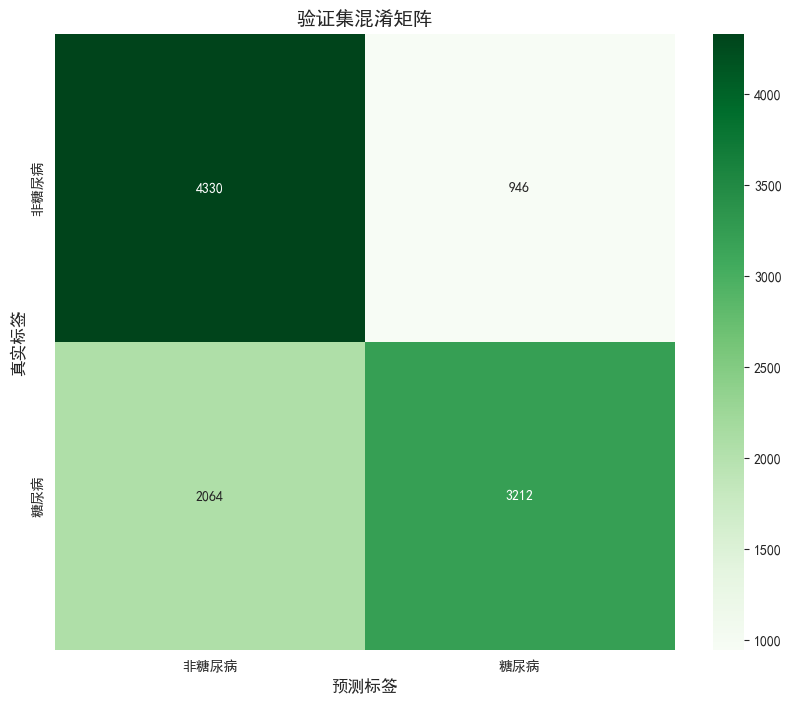

In [25]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_curve
import xgboost as xgb
from lightgbm import LGBMClassifier

# 1. 读数据
X_train = pd.read_csv("sign/X_train.csv")
y_train = pd.read_csv("sign/y_train.csv").values.ravel()
X_val = pd.read_csv("sign/X_val.csv")
y_val = pd.read_csv("sign/y_val.csv").values.ravel()
X_test = pd.read_csv("sign/X_test.csv")
y_test = pd.read_csv("sign/y_test.csv").values.ravel()

# 2. 初始化基模型
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    random_state=42,
    n_estimators=3000,
    learning_rate=0.01,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=3,
    reg_alpha=0.1,
    reg_lambda=1,
    eval_metric='auc'
)

lgb_model = LGBMClassifier(
    objective='binary',
    random_state=42,
    n_estimators=10000,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=2,
    reg_alpha=0.1,
    reg_lambda=1
)

rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=8,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# 3. 各模型分别训练
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=100
)

lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
)

rf_model.fit(X_train, y_train)

# 4. 创建 Stacking 模型
stack_model = StackingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('lgb', lgb_model),
        ('rf', rf_model)
    ],
    final_estimator=make_pipeline(
        StandardScaler(),
        LogisticRegression(max_iter=1000)
    ),
    cv=5,
    n_jobs=-1,
    passthrough=True
)
# 5. 拟合 Stacking 模型
stack_model.fit(X_train, y_train)

# 6. 预测测试集概率
y_proba = stack_model.predict_proba(X_test)[:, 1]

threshold = 0.65
y_pred = (y_proba >= threshold).astype(int)

# 8. 模型评估
print("\n✅ 测试集分类报告（Stacking）:")
print(classification_report(y_test, y_pred))
print("混淆矩阵:")
print(confusion_matrix(y_test, y_pred))
print("准确率:", accuracy_score(y_test, y_pred))

